# Notebook 3: Classification Using Machine Learning

In this notebook, we will use a classical machine learning method to classify the astronomical data saved in the previous notebook.

---

### Necessaries packages

We will import the differents libraries used in this notebook.


In [2]:
import numpy as np
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pickle
from joblib import Parallel, delayed
import multiprocessing


### Reading the data

We will load the saved image and label data from the NumPy files.

Also, we are going to split the training dataset in training and validation datasets
create a new validation set by splitting the original training data (80% for new training, 20% for new validation)


The code loads pre-existing training, validation, and test datasets (images and labels) from .npy files.

It prints the dimensions (shapes) of these initially loaded datasets.

It then disregards the initially loaded validation set and creates a new validation set by splitting the original training data (80% for new training, 20% for new validation), ensuring class proportions are maintained (stratify).

Finally, it prints the dimensions of these newly created training and validation sets, which will likely be used for the subsequent model training and evaluation during development. The original test set remains untouched for final evaluation.

In [3]:
# Load the datasets
train_images = np.load('data/train_images.npy')
train_labels = np.load('data/train_labels.npy')
val_images = np.load('data/val_images.npy')
val_labels = np.load('data/val_labels.npy')

# Print basic information about each dataset before splitting
print(f"Original Training images: {train_images.shape}, Training labels: {train_images.shape}")
print(f"Original Validation images: {val_images.shape}, Validation labels: {val_labels.shape}")

# Split the training data into new training and validation sets (80% train, 20% val)
train_images_new, val_images_new, train_labels_new, val_labels_new = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

# Print the shapes of the new splits
print(f"New Training images: {train_images_new.shape}, New Training labels: {train_labels_new.shape}")
print(f"New Validation images: {val_images_new.shape}, New Validation labels: {val_labels_new.shape}")


Original Training images: (9711, 512, 512, 3), Training labels: (9711, 512, 512, 3)
Original Validation images: (3237, 512, 512, 3), Validation labels: (3237,)
New Training images: (7768, 512, 512, 3), New Training labels: (7768,)
New Validation images: (1943, 512, 512, 3), New Validation labels: (1943,)


### Preprocessing 

The preprocessing consists of two differents functions :

The first function is applied on one image and follow these steps:

- Normalization: The image is converted to a tensor and normalized to a range between 0 and 1 by dividing by 255.0.
  
- Resizing: The image is resized to the target_size to reduce its dimensionality.

- Contrast Adjustment: The contrast of the image is enhanced using a factor of 1.5.

- Clipping: Values are clipped to ensure they remain within the range [0.0, 1.0].

- Flattening: The processed image is converted back to a NumPy array and flattened into a 1D array.


The second function applies this single-image preprocessing to an entire dataset by leveraging parallel processing with joblib, resulting in a standard feature matrix. 

- Parallel Processing: The function utilizes the Parallel and delayed functions from the joblib library to apply preprocess_image_for_ml to each image in the dataset concurrently.

- Feature Matrix Creation: The processed images are stacked into a feature matrix, where each row corresponds to a flattened, preprocessed image.




In [4]:
# Preprocessing function for traditional ML
def preprocess_image_for_ml(image, target_size=(64, 64)):
    """
    Preprocesses an image for traditional ML by resizing, normalizing, and flattening.
    
    Parameters:
    - image: Input image (numpy array)
    - target_size: Tuple of (height, width) to resize the image (default: 64x64)
    
    Returns:
    - Flattened 1D array of preprocessed image
    """
    # Convert image to tensor for preprocessing
    img = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    img = tf.image.resize(img, target_size)  # Resize to reduce dimensionality
    img = tf.image.adjust_contrast(img, contrast_factor=1.5)  # Enhance contrast
    img = tf.clip_by_value(img, 0.0, 1.0)  # Clip values
    
    # Convert to numpy and flatten
    img = img.numpy().flatten()
    return img

# Function to preprocess the entire dataset with parallelization
def preprocess_dataset_for_ml(images, target_size=(64, 64), n_jobs=-1):
    """
    Preprocesses an entire dataset for traditional ML using parallel processing.
    
    Parameters:
    - images: NumPy array of images
    - target_size: Tuple of (height, width) for resizing
    - n_jobs: Number of parallel jobs (default: -1, use all available cores)
    
    Returns:
    - Preprocessed feature matrix (n_samples, n_features)
    """
    # Use Parallel to process images across multiple cores
    preprocessed_images = Parallel(n_jobs=n_jobs, verbose=1)(
        delayed(preprocess_image_for_ml)(img, target_size) for img in images
    )
    # Stack into a feature matrix
    return np.array(preprocessed_images)

- Label encoding: This part encodes categorical labels into numerical format, which is necessary for machine learning algorithms that require numerical input.
- Preprocessing Datasets with Parallelization : This section preprocesses the image datasets using a smaller target size (64x64 pixels) for reduced dimensionality and efficiency.

In [5]:
# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels_new)
val_labels_encoded = label_encoder.transform(val_labels_new)
valid_labels_encoded = label_encoder.transform(val_labels)

# Preprocess the datasets with parallelization
# Use a smaller target size (64x64) to reduce dimensionality for traditional ML
target_size = (64, 64)
num_cores = multiprocessing.cpu_count()
print(f"Using {num_cores} CPU cores for parallel preprocessing...")

print("Preprocessing training images...")
X_train = preprocess_dataset_for_ml(train_images_new, target_size, n_jobs=num_cores)
print("Preprocessing validation_train images...")
X_val = preprocess_dataset_for_ml(val_images_new, target_size, n_jobs=num_cores)
print("Preprocessing validation images...")
X_valid = preprocess_dataset_for_ml(val_images, target_size, n_jobs=num_cores)

# Labels are already in class index format
y_train = train_labels_encoded
y_val = val_labels_encoded
y_valid = valid_labels_encoded

# Print shapes of preprocessed data
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_valid.shape}, y_test shape: {y_valid.shape}")

Using 16 CPU cores for parallel preprocessing...
Preprocessing training images...


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
2025-04-17 11:48:22.080384: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-17 11:48:22.084695: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-17 11:48:22.096316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-17 11:48:22.109484: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-17 11:48:22.110517: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-17 11:48:22.111252: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your mach

Preprocessing validation_train images...


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    1.7s
[Parallel(n_jobs=16)]: Done 1512 tasks      | elapsed:    4.7s
[Parallel(n_jobs=16)]: Done 1943 out of 1943 | elapsed:    6.0s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


Preprocessing validation images...


[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    1.7s
[Parallel(n_jobs=16)]: Done 1512 tasks      | elapsed:    4.9s
[Parallel(n_jobs=16)]: Done 2912 tasks      | elapsed:    9.5s


X_train shape: (7768, 12288), y_train shape: (7768,)
X_val shape: (1943, 12288), y_val shape: (1943,)
X_test shape: (3237, 12288), y_test shape: (3237,)


[Parallel(n_jobs=16)]: Done 3237 out of 3237 | elapsed:   10.5s finished


### Visualising the data after pre-processing

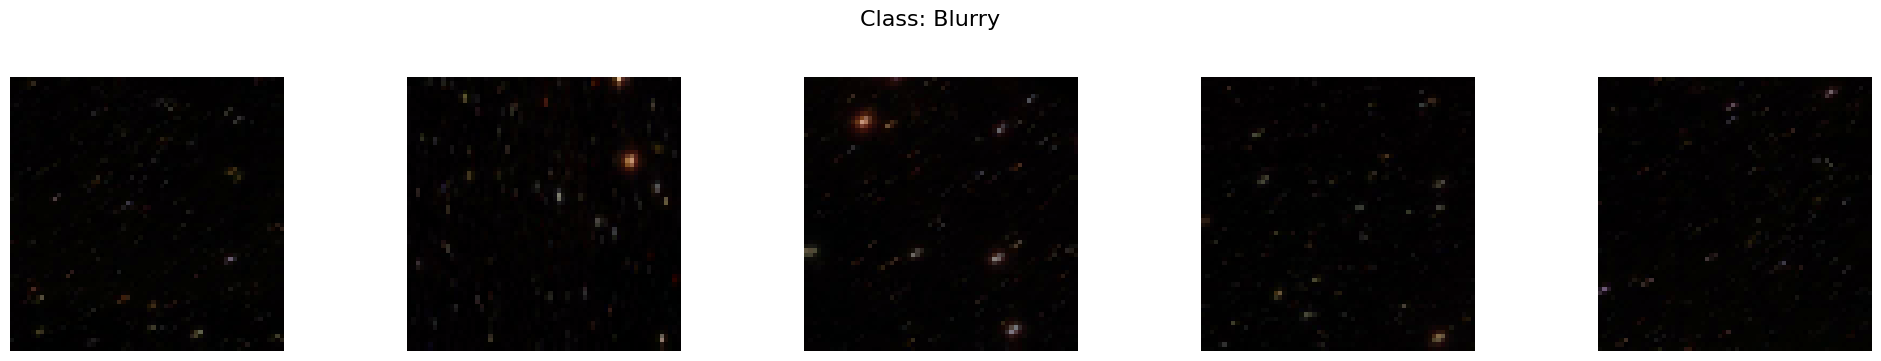

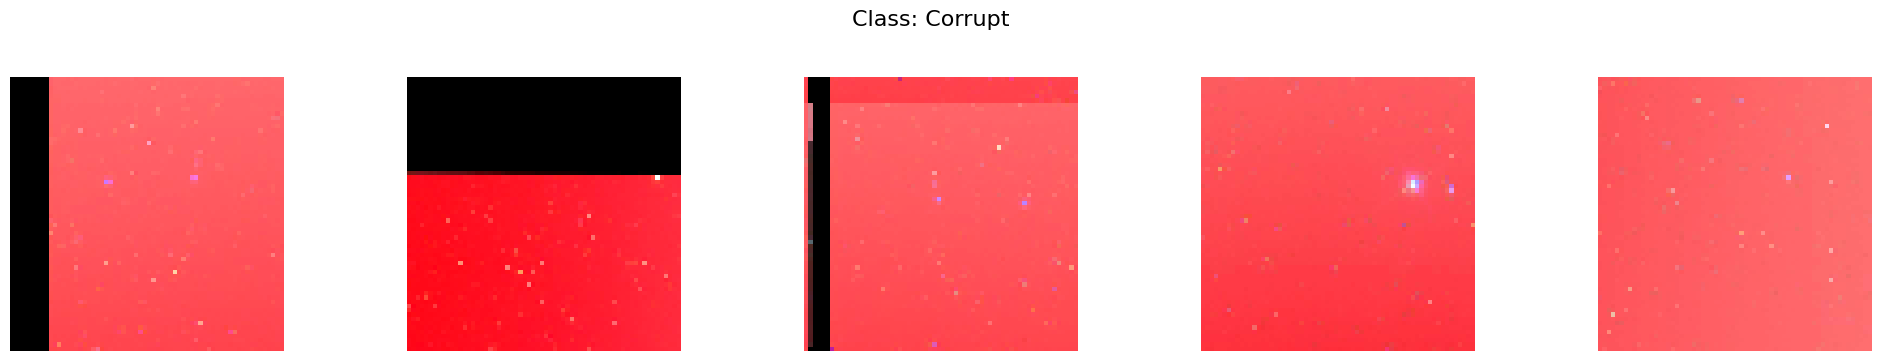

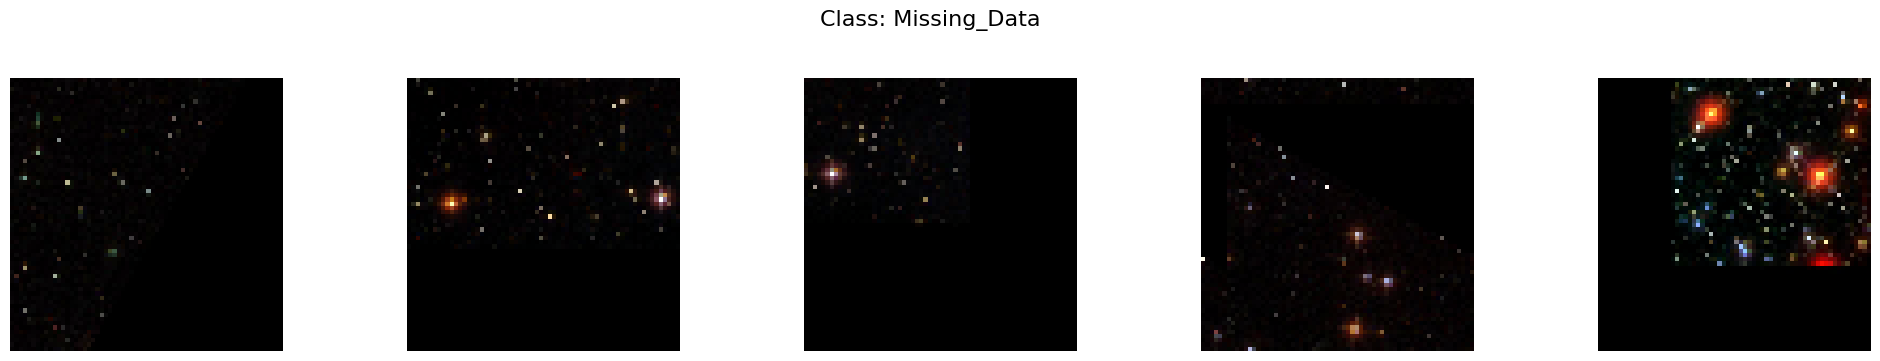

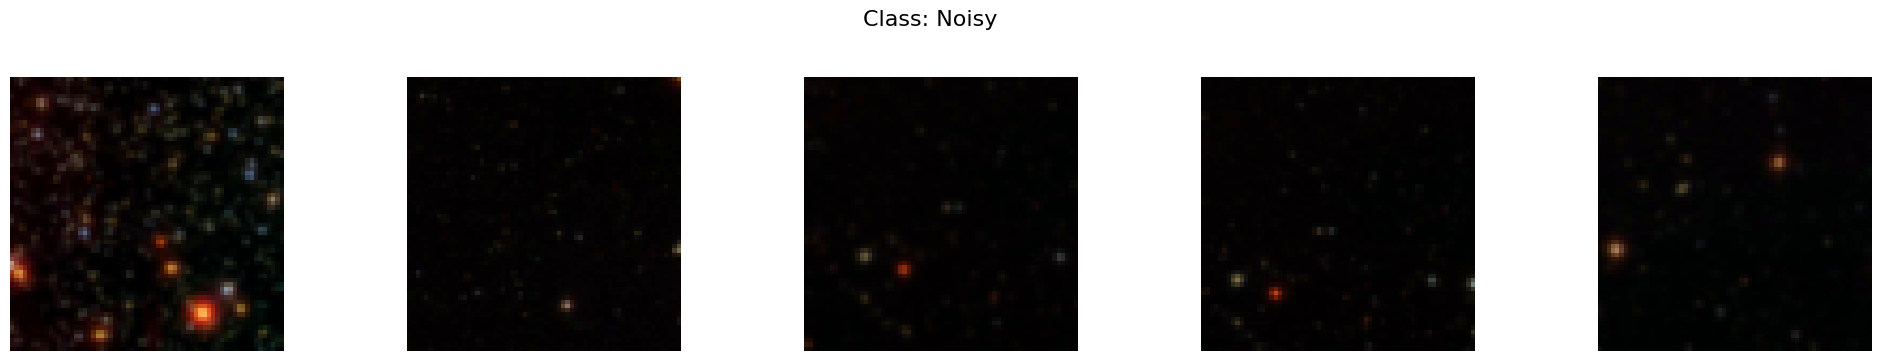

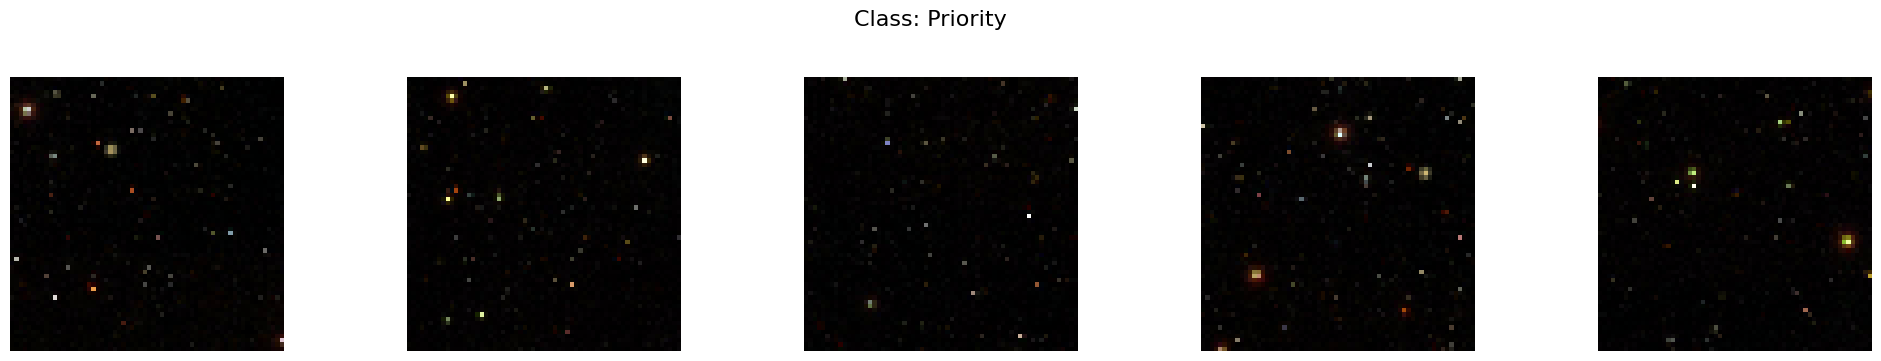

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Define the class names
class_names = ["Blurry", "Corrupt", "Missing_Data", "Noisy", "Priority"]

# Get the unique labels in the training set
unique_labels = np.unique(y_train)  # Use encoded labels

# Display the first 5 images for each class after preprocessing
for label in unique_labels:
    # Find the indices of images belonging to the current class
    class_indices = np.where(y_train == label)[0]
    
    # Select the first 5 images of this class
    num_images_to_display = min(5, len(class_indices))
    selected_indices = class_indices[:num_images_to_display]
    selected_images = X_train[selected_indices]  # Use preprocessed images (X_train)

    # Plot the selected images
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 4))
    fig.suptitle(f'Class: {class_names[label]}', fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    for i, ax in enumerate(axes):
        ax.imshow(selected_images[i].reshape(64, 64, 3))  # Reshape for 64x64 RGB images
        ax.axis('off')
    
    plt.show()
    print()

Overall, the preprocessing steps  not only enhance the visual quality of the images but also improve the data's integrity, making it more suitable for machine learning applications. This dual impact leads to better model performance, efficiency, and interpretability, ultimately contributing to more reliable outcomes in data-driven tasks.

## ML Classification

We have choosen a Random Forest classifier justified by its robustness, ability to handle complex relationships, ease of use, and effective handling of high-dimensional data. These characteristics make it a suitable model for the given classification task, particularly when dealing with our preprocessed image data.

In [7]:
%%time
# Train a Random Forest classifier with parallelization
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
print("Training Random Forest model with parallelization...")
rf_model.fit(X_train, y_train)


Training Random Forest model with parallelization...
CPU times: user 1min 47s, sys: 16.2 ms, total: 1min 47s
Wall time: 7.58 s


RandomForestClassifier(n_jobs=-1, random_state=42)

### Save the model

In [8]:
# Save the model using pickle
with open('models/rf_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)
print("Model saved as 'rf_model.pkl'")


Model saved as 'rf_model.pkl'


### Evaluation of the model

In [9]:
# Evaluate on validation set (to simulate test accuracy equivalent)
val_accuracy = rf_model.score(X_val, y_val)
print(f"Validation accuracy: {val_accuracy:.4f}")

# Evaluate on test set
valid_accuracy = rf_model.score(X_valid, y_valid)
print(f"Validation accuracy: {valid_accuracy:.4f}")

# Make predictions on the test set
valid_predictions = rf_model.predict(X_valid)

# Verify shapes for debugging
print(f"test_predictions shape: {valid_predictions.shape}")
print(f"y_test shape: {y_valid.shape}")

# Detailed classification report
print("\nClassification Report for Test Set:")
print(classification_report(y_valid, valid_predictions, target_names=['Blurry', 'Corrupt', 'Missing_Data', 'Noisy', 'Priority']))


Validation accuracy: 0.8044
Validation accuracy: 0.7887
test_predictions shape: (3237,)
y_test shape: (3237,)

Classification Report for Test Set:
              precision    recall  f1-score   support

      Blurry       0.74      0.26      0.39       727
     Corrupt       1.00      1.00      1.00       222
Missing_Data       0.96      0.95      0.95       421
       Noisy       0.89      0.84      0.86       721
    Priority       0.69      0.99      0.81      1146

    accuracy                           0.79      3237
   macro avg       0.85      0.81      0.80      3237
weighted avg       0.80      0.79      0.76      3237



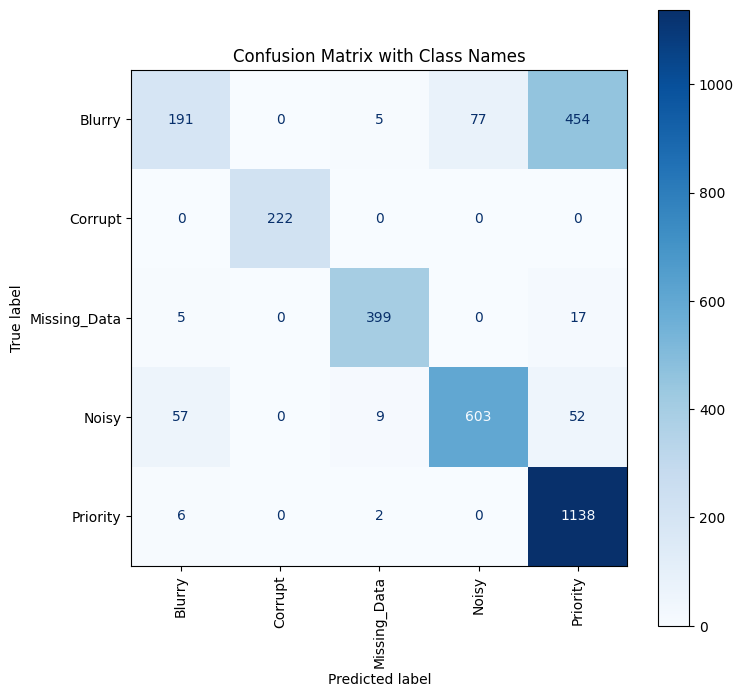

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define class names
class_names = ["Blurry", "Corrupt", "Missing_Data", "Noisy", "Priority"]

# Compute the confusion matrix
cm = confusion_matrix(val_labels, valid_predictions)

# Plot the confusion matrix with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Customize and display the plot
fig, ax = plt.subplots(figsize=(8, 8))  # Set the figure size
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')  # Use a blue colormap
plt.title("Confusion Matrix with Class Names")
plt.show()

The model performs excellently on 'Corrupt' and 'Missing_Data' and reasonably well on 'Noisy'. However, its overall performance is significantly hampered by its inability to correctly identify 'Blurry' images (very low recall) and its tendency to over-predict the 'Priority' class (leading to low precision for 'Priority'). The core issue seems to be the confusion between 'Blurry' and 'Priority' – the model mistakes many blurry images for priority images. Addressing this specific confusion is key to improving the overall performance.

#### **⚠️ Freeing up Space**

In [11]:
import gc

# Remove the data from memory
del val_images, val_labels, train_images, train_labels

# Force garbage collection to free up memory
gc.collect()

# Clear the input/output cache
print("Data and models removed from memory.")

Data and models removed from memory.
